<div style="text-align: right">INFO 6106 Neural Modeling, Final Project, Milestone 2</div>
<div style="text-align: right">Lokeshwaran Balamurugan, Nitin Sai Varma Indukuri, Krishica Gopalakrishnan</div>

# 48-Hour Window Hybrid Model (with Automatic Weights)

**Objective**
Train hybrid models that combine meteorological and satellite image data, exploring different architectures.

**Tasks**

**Model Training**
- Train different hybrid models integrating meteorological and image data.
- Note: Below are potential guidelines or ideas; you can choose to do them:
  - Model 1: ConvLSTM2D + LSTM (Shallow).
  - Model 2: Conv3D + ConvLSTM2D + LSTM (Shallow).
  - Model 3: ConvLSTM2D + LSTM (Deep).
  - Model 4: Conv3D + ConvLSTM2D + LSTM (Deep).
  - Experiment with different input window sizes (e.g., 24-hour meteorological + 8-hour image vs. 48-hour meteorological + 16-hour image, etc.).
  - Fine-tune hyperparameters for each model.

**Evaluation and Insights**
- Evaluate models using classification metrics (e.g., accuracy, F1-score) and generate confusion matrices.
- Plot training and validation loss/accuracy curves for each model.
- Compare model performances and document findings.


This notebook focuses on developing and evaluating hybrid deep learning models that integrate meteorological and satellite image data for spatiotemporal analysis for the **48-Hour Window**, where we'll be giving the model an 48-Hour Sequential Meteorological data and 16-satellite images to predict the class of rainfall for the **next-to-next day**. And in this notebook, we'll be using tensorflow's inbuilt libraries to calculate the class weights for the model training. By leveraging both sequential meteorological features and spatial features from satellite images, we aim to create robust models capable of accurate predictions or classifications.

## 1. Importing Necessary Libraries

These libraries are essential for tasks involving data preprocessing, visualization, and model development. Libraries like os, pandas, and numpy facilitate loading, cleaning, and manipulating both meteorological time-series and satellite image data, while pickle helps save and reuse processed datasets or trained models. Image-specific tools like PIL and cv2 enable resizing, augmenting, and transforming satellite images for model input, and SMOTE addresses class imbalance in datasets. Visualization libraries, including matplotlib and seaborn, help track training progress and evaluate model performance using plots such as confusion matrices and learning curves. Lastly, utility libraries like tqdm enhance workflow efficiency with progress bars, and warnings ensures clean, readable outputs by suppressing unnecessary alerts.

In [1]:
# Data Manipulation Libraries
import os
import pandas as pd
import numpy as np
import pickle
import ast

# Plotting Libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

# Image Processing Libraries
from PIL import Image, ImageOps
import cv2

from imblearn.over_sampling import SMOTE

# Utility Libraries
from tqdm import tqdm

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

## 2. Loading Data

We'll now preprocess and manage the datasets required for training hybrid models that combine meteorological and satellite image data. To achieve this, we start by defining different temporal window sizes such as 24, 48, and 72 hours, along with the corresponding number of satellite images and prediction shifts for each window size. These settings will allow us to experiment with varying input-output configurations.

In [2]:
# Define window sizes and corresponding number of images
window_sizes = [24, 48, 72]  # in hours
images_per_window_dict = {24: 8, 48: 16, 72: 24}

# Define the prediction shift for each window size
prediction_shifts = {24: 24, 48: 48, 72: 72}

# window_sizes = [24]  # in hours
# images_per_window_dict = {24: 8}

# # Define the prediction shift for each window size
# prediction_shifts = {24: 24}

# Define meteorological features to include
meteo_features = [
    'Temp_F', 'RH_pct', 'Dewpt_F', 'Wind_Spd_mph',
    'Wind_Direction_deg', 'Peak_Wind_Gust_mph',
    'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
    'High_Cloud_Ht_ft', 'Visibility_mi',
    'Atm_Press_hPa', 'Sea_Lev_Press_hPa',
    'Altimeter_hPa', 'Precip_in'
]

Next, we'll set up a directory to store all preprocessed data, ensuring that previously processed datasets can be reused. For each window size, we'll check if the required preprocessed files exist. If they do, we'll load them, including meteorological data, satellite image data, target variables, and timestamps. These timestamps will help us maintain the temporal sequence and alignment necessary for accurate modeling.

In [3]:
# Dictionary to store processed data
data_windows = {window_size: {'X_meteo': [], 'X_images': [], 'y': [], 'timestamps': []} for window_size in window_sizes}

In [4]:
import os
import pickle

# Directory to store preprocessed data
data_dir = r"\Users\nitin\Music\Neural Modeling Methods and Tools\Assignments\Final Project\data1"
os.makedirs(data_dir, exist_ok=True)

# Dictionary to hold filepaths for processed data, including timestamps
data_files = {
    window_size: {
        'X_meteo': os.path.join(data_dir, f"X_meteo_{window_size}.pkl"),
        'X_images': os.path.join(data_dir, f"X_images_{window_size}.pkl"),
        'y': os.path.join(data_dir, f"y_{window_size}.pkl"),
        'timestamps': os.path.join(data_dir, f"timestamps_{window_size}.pkl"),  # Add timestamps
    } for window_size in window_sizes
}


# Dictionary to store processed data
data_windows = {window_size: {'X_meteo': [], 'X_images': [], 'y': [], 'timestamps': []} for window_size in window_sizes}

for window_size in window_sizes:
    print(f"\nProcessing data for window size: {window_size} hours")
    
    # Prediction shift for the current window size
    prediction_shift = prediction_shifts[window_size]
    
    # Check if all files exist for this window size
    if all(os.path.exists(data_files[window_size][key]) for key in ['X_meteo', 'X_images', 'y']):
        print(f"Data exists for window size: {window_size}. Loading...")
        
        # Load preprocessed data
        with open(data_files[window_size]['X_meteo'], 'rb') as f:
            data_windows[window_size]['X_meteo'] = pickle.load(f)
        with open(data_files[window_size]['X_images'], 'rb') as f:
            data_windows[window_size]['X_images'] = pickle.load(f)
        with open(data_files[window_size]['y'], 'rb') as f:
            data_windows[window_size]['y'] = pickle.load(f)
        with open(data_files[window_size]['timestamps'], 'rb') as f:  # Load timestamps
            data_windows[window_size]['timestamps'] = pickle.load(f)
        
        print(f"Loaded data for window size {window_size}: "
              f"X_meteo shape {np.array(data_windows[window_size]['X_meteo']).shape}, "
              f"X_images shape {np.array(data_windows[window_size]['X_images']).shape}, "
              f"y shape {np.array(data_windows[window_size]['y']).shape}")
print("Processing complete.")


Processing data for window size: 24 hours
Data exists for window size: 24. Loading...
Loaded data for window size 24: X_meteo shape (47834, 24, 14), X_images shape (47834, 32768), y shape (47834,)

Processing data for window size: 48 hours
Data exists for window size: 48. Loading...
Loaded data for window size 48: X_meteo shape (47786, 48, 14), X_images shape (47786, 65536), y shape (47786,)

Processing data for window size: 72 hours
Data exists for window size: 72. Loading...
Loaded data for window size 72: X_meteo shape (47738, 72, 14), X_images shape (47738, 98304), y shape (47738,)
Processing complete.


Now that we have all the data loaded, let's look at a couple of our sliding window samples from the 48-Hour Window that we are going to use to train this model.

In [5]:
def display_sliding_window_samples(data_windows, window_size, num_samples=24):
    """
    Display sliding window samples including meteorological data, associated images with timestamps, and window timeframe.

    Args:
        data_windows (dict): Contains 'X_meteo', 'X_images', 'timestamps', and 'y' for each window size.
        window_size (int): Size of the sliding window (24, 48, or 72 hours).
        num_samples (int): Number of sliding window samples to display.
    """
    # Extract relevant data for the given window size
    X_meteo = np.array(data_windows[window_size]['X_meteo'])
    X_images = np.array(data_windows[window_size]['X_images']).reshape(-1, images_per_window_dict[window_size], 64, 64)
    y = np.array(data_windows[window_size]['y'])
    timestamps = np.array(data_windows[window_size]['timestamps'])

    # Feature column names for meteorological data
    meteo_columns = [
        'Temp_F', 'RH_pct', 'Dewpt_F', 'Wind_Spd_mph', 'Wind_Direction_deg',
        'Peak_Wind_Gust_mph', 'Low_Cloud_Ht_ft', 'Med_Cloud_Ht_ft',
        'High_Cloud_Ht_ft', 'Visibility_mi', 'Atm_Press_hPa',
        'Sea_Lev_Press_hPa', 'Altimeter_hPa', 'Precip_in'
    ]

    # Display the selected number of samples
    for i in range(min(num_samples, len(X_meteo))):
        print(f"Sample {i + 1} (Window Size: {window_size} hours)")
        print(f"Timeframe: {timestamps[i][0]} to {timestamps[i][-1]}")
        print("--------------------------------------------------")

        # Display meteorological data
        print("Meteorological Data:")
        display(pd.DataFrame(X_meteo[i], columns=meteo_columns))
        print(f"Target (y): {y[i]}")

        # Plot images with timestamps
        fig, axes = plt.subplots(1, X_images.shape[1], figsize=(20, 5))
        plt.suptitle(f"Images for Sample {i + 1} (Window {window_size} hours)")

        for j, (img, ts) in enumerate(zip(X_images[i], timestamps[i])):
            ax = axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            ax.set_title(ts if ts != "No Image" else "Placeholder")

        plt.tight_layout()
        plt.show()

In [6]:
# # Display the first 24 samples for a 24-hour window
# display_sliding_window_samples(data_windows, window_size=24, num_samples=24)

## 3. Removing Corrupt Timestamps

Here’s how we will approach the task of filtering out corrupt time stamps:
- <b>Iterate Through Each Window Size:</b> For each window size, we will loop through the timestamps associated with the sliding windows. Our goal will be to identify valid windows where none of the timestamps are part of the corrupt_timestamps list.
- <b>Filter Valid Indices:</b> Using a list comprehension, we will check every sliding window's timestamps. If a window’s timestamps do not contain any corrupt entries, we will add that index to the list of valid indices for the respective window size.

In [7]:
# Load corrupt timestamps from the pickle file
with open(r'\Users\nitin\Music\Neural Modeling Methods and Tools\Assignments\Final Project\data1\corrupt_timestamps.pkl', 'rb') as f:
    corrupt_timestamps = pickle.load(f)

print(f"Loaded {len(corrupt_timestamps)} corrupt timestamps")

Loaded 2920 corrupt timestamps


Once loaded, we'll calculate valid indices for each defined window size (24, 48, and 72 hours) by checking each window's timestamps and excluding those with any corrupt entries.

In [8]:
# Dictionary to store valid indices for each window size
valid_indices_all = {}

# Calculate valid indices for each window size
for window_size in [24, 48, 72]:
    print(f"\nCalculating valid indices for window size: {window_size} hours")
    
    # Get valid indices
    valid_indices_all[window_size] = [
        idx
        for idx, timestamps in enumerate(data_windows[window_size]['timestamps'])
        if not any(ts in corrupt_timestamps for ts in timestamps if ts != "No Image")
    ]
    
    print(f"Total valid windows ({window_size}): {len(valid_indices_all[window_size])} "
          f"out of {len(data_windows[window_size]['timestamps'])}")


Calculating valid indices for window size: 24 hours
Total valid windows (24): 39067 out of 47834

Calculating valid indices for window size: 48 hours
Total valid windows (48): 38995 out of 47786

Calculating valid indices for window size: 72 hours
Total valid windows (72): 38923 out of 47738


Now that we know which timestamps are corrputed, we are now going to filter them out:
- <b>Filter Data for Each Window Size:</b>
    For each window size, we will:
    - Retrieve the valid indices from valid_indices_all that we calculated earlier.
    - Use these indices to filter the corresponding data in data_windows. This step ensures that only valid sliding windows are included, based on the clean timestamps.
- <b>Store the Filtered Data:</b> For each window size, we will store the filtered meteorological data, image data, target labels, and timestamps in filtered_data_all. This allows us to keep the data organized and ready for further processing.

In [9]:
# Dictionary to store filtered data for each window size
filtered_data_all = {}

# Filter data for each window size
for window_size in [24, 48, 72]:
    print(f"\nFiltering data for window size: {window_size} hours")
    
    valid_indices = valid_indices_all[window_size]
    
    # Filter the data
    filtered_data_all[window_size] = {
        'X_meteo': np.array(data_windows[window_size]['X_meteo'])[valid_indices],
        'X_images': np.array(data_windows[window_size]['X_images'])[valid_indices],
        'y': np.array(data_windows[window_size]['y'])[valid_indices],
        'timestamps': np.array(data_windows[window_size]['timestamps'])[valid_indices],
    }
    
    # Print shapes
    print(f"Filtered X_meteo shape ({window_size}): {filtered_data_all[window_size]['X_meteo'].shape}")
    print(f"Filtered X_images shape ({window_size}): {filtered_data_all[window_size]['X_images'].shape}")
    print(f"Filtered y shape ({window_size}): {filtered_data_all[window_size]['y'].shape}")
    print(f"Filtered timestamps shape ({window_size}): {filtered_data_all[window_size]['timestamps'].shape}")


Filtering data for window size: 24 hours
Filtered X_meteo shape (24): (39067, 24, 14)
Filtered X_images shape (24): (39067, 32768)
Filtered y shape (24): (39067,)
Filtered timestamps shape (24): (39067, 8)

Filtering data for window size: 48 hours
Filtered X_meteo shape (48): (38995, 48, 14)
Filtered X_images shape (48): (38995, 65536)
Filtered y shape (48): (38995,)
Filtered timestamps shape (48): (38995, 16)

Filtering data for window size: 72 hours
Filtered X_meteo shape (72): (38923, 72, 14)
Filtered X_images shape (72): (38923, 98304)
Filtered y shape (72): (38923,)
Filtered timestamps shape (72): (38923, 24)


# 4. Stratified Train-Test Splitting

Now, let us perform a train, test and validation split on the data. But, we will not split the data randomly like we normally do.

- We are going to perfomr <b>Stratified Splitting</b>.
    - <b> What is Stratified Splitting of Data?</b>  
        A stratified split is a method of dividing data into training and testing (or validation) subsets while preserving the relative proportion of each class (or category) within the original dataset. This technique is commonly used in classification problems to ensure that all classes are fairly represented in both subsets.
- <b>Create a Balanced Validation Set:</b> Where we make sure that every class in the validation set has an equal number of samples, avoiding class imbalance during evaluation.
- <b>One Hot Encode Labels:</b> We convert both training and validation sets into one-hot encoded format.
    - <b>What is One Hot Encoding?</b>
         One-hot encoding is a technique used to represent categorical data as a binary matrix. Each category is converted into a unique vector with binary values (0 and 1), where only one element is set to 1 to indicate the presence of that category, and all other elements are set to 0.

In [10]:
from sklearn.model_selection import StratifiedShuffleSplit
from tensorflow.keras.utils import to_categorical
import numpy as np

# Function to display class distributions
def print_class_distribution(y, name):
    unique, counts = np.unique(y, return_counts=True)
    print(f"\nClass distribution in {name}:")
    for cls, count in zip(unique, counts):
        print(f"  Class {cls}: {count} ({count / len(y) * 100:.2f}%)")

# Function to split data and create balanced train/validation sets
def prepare_data_stratified(data, classes, test_size=0.2, samples_per_class=126):
    """
    Stratified split of data into train and validation sets with balanced validation classes.

    Args:
        data (dict): Filtered data for a specific window size.
        classes (array): Unique classes in the dataset.
        test_size (float): Proportion of data to use for validation.
        samples_per_class (int): Number of samples per class for the balanced validation set.

    Returns:
        dict: Train and validation datasets for the window size.
    """
    X_meteo = data['X_meteo']
    X_images = data['X_images'].reshape(-1, images_per_window_dict[len(X_meteo[0])], 64, 64, 1)
    y = data['y']
    timestamps = data['timestamps']

    # Stratified split into train and temp (temp will later be split into balanced validation)
    sss = StratifiedShuffleSplit(n_splits=1, test_size=test_size, random_state=42)
    for train_index, val_index in sss.split(X_meteo, y):
        X_train_meteo, X_temp_meteo = X_meteo[train_index], X_meteo[val_index]
        y_train, y_temp = y[train_index], y[val_index]
        X_train_images, X_temp_images = X_images[train_index], X_images[val_index]
        timestamps_train = timestamps[train_index]
        timestamps_temp = timestamps[val_index]

    # Create a balanced validation set with equal samples per class
    balanced_val_indices = []
    for c in classes:
        class_indices = np.where(y_temp == c)[0]
        if len(class_indices) < samples_per_class:
            balanced_val_indices.extend(np.random.choice(class_indices, samples_per_class, replace=True))
        else:
            balanced_val_indices.extend(np.random.choice(class_indices, samples_per_class, replace=False))

    # Prepare balanced validation data
    X_val_balanced_meteo = X_temp_meteo[balanced_val_indices]
    X_val_balanced_images = X_temp_images[balanced_val_indices]
    y_val_balanced = y_temp[balanced_val_indices]
    timestamps_val_balanced = timestamps_temp[balanced_val_indices]

    # One-hot encode the labels for train and validation
    y_train_onehot = to_categorical(y_train, num_classes=len(classes))
    y_val_balanced_onehot = to_categorical(y_val_balanced, num_classes=len(classes))

    # Print class distributions
    print_class_distribution(y_train, "Train Set")
    print_class_distribution(y_val_balanced, "Balanced Validation Set")

    return {
        'X_train_meteo': X_train_meteo,
        'X_train_images': X_train_images,
        'y_train': y_train_onehot,
        'timestamps_train': timestamps_train,
        'X_val_meteo': X_val_balanced_meteo,
        'X_val_images': X_val_balanced_images,
        'y_val': y_val_balanced_onehot,
        'timestamps_val': timestamps_val_balanced,
    }

# Prepare train and validation data for all window sizes
prepared_data_all = {}

for window_size in [24, 48, 72]:
    print(f"\nPreparing stratified data split for {window_size}-hour window.")
    classes = np.unique(filtered_data_all[window_size]['y'])
    prepared_data_all[window_size] = prepare_data_stratified(filtered_data_all[window_size], classes)

    # Print dataset shapes
    print(f"\nShapes for {window_size}-hour window size:")
    print(f"Train Meteo: {prepared_data_all[window_size]['X_train_meteo'].shape}, ")
    print(f"Train Images: {prepared_data_all[window_size]['X_train_images'].shape}, ")
    print(f"Train Labels: {prepared_data_all[window_size]['y_train'].shape}")
    print(f"Validation Meteo: {prepared_data_all[window_size]['X_val_meteo'].shape}, ")
    print(f"Validation Images: {prepared_data_all[window_size]['X_val_images'].shape}, ")
    print(f"Validation Labels: {prepared_data_all[window_size]['y_val'].shape}")



Preparing stratified data split for 24-hour window.

Class distribution in Train Set:
  Class 0: 422 (1.35%)
  Class 1: 1029 (3.29%)
  Class 2: 783 (2.51%)
  Class 3: 29019 (92.85%)

Class distribution in Balanced Validation Set:
  Class 0: 126 (25.00%)
  Class 1: 126 (25.00%)
  Class 2: 126 (25.00%)
  Class 3: 126 (25.00%)

Shapes for 24-hour window size:
Train Meteo: (31253, 24, 14), 
Train Images: (31253, 8, 64, 64, 1), 
Train Labels: (31253, 4)
Validation Meteo: (504, 24, 14), 
Validation Images: (504, 8, 64, 64, 1), 
Validation Labels: (504, 4)

Preparing stratified data split for 48-hour window.

Class distribution in Train Set:
  Class 0: 421 (1.35%)
  Class 1: 1027 (3.29%)
  Class 2: 783 (2.51%)
  Class 3: 28965 (92.85%)

Class distribution in Balanced Validation Set:
  Class 0: 126 (25.00%)
  Class 1: 126 (25.00%)
  Class 2: 126 (25.00%)
  Class 3: 126 (25.00%)

Shapes for 48-hour window size:
Train Meteo: (31196, 48, 14), 
Train Images: (31196, 16, 64, 64, 1), 
Train Labels:

## 5. Feature Importance

- In order for us to analyze the meterological data, to predict outcomes, we can make the process more efficient by choosing the most important featurfes to predict the outcomes.
- To do this, we’ll train a Random Forest model, which will help us evaluate how much each feature contributes to making accurate predictions.
- As soon as that is done, we'll calculate average importance scores for each feature, sort them by relevance, and pick the top ones. This process will allow us to focus on the key factors driving predictions, making our analysis more streamlined and efficient.

<b>Helper Function: Compute Top Features</b>

In [11]:
from sklearn.ensemble import RandomForestClassifier

# Compute top features (meteorological data only) after filtering
def compute_top_features_filtered(X_train_meteo, y_train, top_n=10):
    # Flatten the meteorological data
    X_flat = X_train_meteo.reshape(X_train_meteo.shape[0], -1)
    
    # Initialize and train the RandomForestClassifier
    rf = RandomForestClassifier(n_estimators=100, random_state=42)
    rf.fit(X_flat, y_train.argmax(axis=1))  # Convert one-hot to class indices
    
    # Get feature importances
    feature_importance = rf.feature_importances_
    
    # Reshape importance to match original feature structure
    reshaped_importance = feature_importance.reshape(X_train_meteo.shape[1], -1)
    
    # Aggregate importance across features
    aggregated_importance = reshaped_importance.mean(axis=0)
    
    # Create a DataFrame for easier handling
    importance_df = pd.DataFrame({
        'Feature': [f"Feature {i}" for i in range(X_train_meteo.shape[2])],
        'Importance': aggregated_importance
    })
    
    # Sort features by importance
    importance_df.sort_values(by='Importance', ascending=False, inplace=True)
    
    # Select top_n features
    top_features = importance_df.head(top_n).index.tolist()
    
    return top_features

Now, we'll use the helper function we defined above, to do the following:
- <b>Iterate over Window Sizes</b> (24, 48, and 72 hours)
- <b>Identify Top Features:</b> Using the helper function to compute the top features, we compute the average feature importance, and select a number of top contenders to be the most important features.
- <b>Reduce Meteorological Data: </b>We’ll filter the training and validation meteorological data, keeping only the identified top features. This reduction helps streamline the dataset without losing critical information.

In [12]:
# Dictionary to store reduced data for all window sizes
reduced_data_filtered_all = {}

# Function to compute top features for all window sizes
for window_size in tqdm([24, 48, 72]):
    print(f"\nComputing top features for window size: {window_size} hours")

    # Extract train data for the current window size
    X_train_meteo = prepared_data_all[window_size]['X_train_meteo']
    y_train = prepared_data_all[window_size]['y_train']
    
    # Compute top features
    top_features_filtered = compute_top_features_filtered(
        X_train_meteo,
        y_train,
        top_n=10
    )
    print(f"Top 10 Features for {window_size}-hour Window (Filtered): {top_features_filtered}")

    # Reduce meteorological data to the top features
    X_train_meteo_reduced = X_train_meteo[:, :, top_features_filtered]
    X_val_meteo_reduced = prepared_data_all[window_size]['X_val_meteo'][:, :, top_features_filtered]

    # Store reduced data for the current window size
    reduced_data_filtered_all[window_size] = {
        'X_train_meteo': X_train_meteo_reduced,
        'X_train_images': prepared_data_all[window_size]['X_train_images'],
        'y_train': prepared_data_all[window_size]['y_train'],
        'timestamps_train': prepared_data_all[window_size]['timestamps_train'],
        'X_val_meteo': X_val_meteo_reduced,
        'X_val_images': prepared_data_all[window_size]['X_val_images'],
        'y_val': prepared_data_all[window_size]['y_val'],
        'timestamps_val': prepared_data_all[window_size]['timestamps_val'],
    }

    # Print reduced shapes
    print(f"Reduced Train Meteo Shape ({window_size}): {X_train_meteo_reduced.shape}")
    print(f"Reduced Validation Meteo Shape ({window_size}): {X_val_meteo_reduced.shape}")

  0%|          | 0/3 [00:00<?, ?it/s]


Computing top features for window size: 24 hours


 33%|███▎      | 1/3 [00:24<00:48, 24.27s/it]

Top 10 Features for 24-hour Window (Filtered): [1, 11, 0, 2, 12, 10, 6, 4, 3, 7]
Reduced Train Meteo Shape (24): (31253, 24, 10)
Reduced Validation Meteo Shape (24): (504, 24, 10)

Computing top features for window size: 48 hours


 67%|██████▋   | 2/3 [01:05<00:34, 34.15s/it]

Top 10 Features for 48-hour Window (Filtered): [1, 0, 12, 11, 2, 6, 10, 3, 4, 7]
Reduced Train Meteo Shape (48): (31196, 48, 10)
Reduced Validation Meteo Shape (48): (504, 48, 10)

Computing top features for window size: 72 hours


100%|██████████| 3/3 [02:02<00:00, 40.86s/it]

Top 10 Features for 72-hour Window (Filtered): [1, 0, 12, 2, 11, 10, 6, 3, 4, 7]
Reduced Train Meteo Shape (72): (31138, 72, 10)
Reduced Validation Meteo Shape (72): (504, 72, 10)


**Visualizing the Most Important Features**

We'll now visualize the first few samples of the filtered and reduced data for the selected window size (e.g., 48 hours). So that we get a chance to examine the structure and content of the meteorological data, associated satellite images, and target labels to ensure everything is properly aligned and formatted for training.



In [13]:
def display_first_n_samples(reduced_data, window_size=24, num_samples=20):
    """
    Display the first n samples of the filtered and reduced data, 
    showing meteorological data, associated images with timestamps, and target labels.
    
    Args:
        reduced_data (dict): Contains 'X_train_meteo', 'X_train_images', 'y_train', 'timestamps_train', 
                             'X_val_meteo', 'X_val_images', 'y_val', 'timestamps_val' for each window size.
        window_size (int): Size of the window (24, 48, 72 hours).
        num_samples (int): Number of samples to display.
    """
    # Extract training data
    X_meteo = reduced_data[window_size]['X_train_meteo']
    X_images = reduced_data[window_size]['X_train_images']
    y = reduced_data[window_size]['y_train']
    timestamps = reduced_data[window_size]['timestamps_train']
    
    # Convert one-hot labels to class indices
    y_labels = np.argmax(y, axis=1)
    
    # Define feature column names for meteorological data
    top_features = [
        f"Feature {i}" for i in range(X_meteo.shape[2])
    ]  # Adjusted to match the reduced features
    
    # Define class names based on unique classes
    num_classes = y.shape[1]
    class_names = [f"Class {i}" for i in range(num_classes)]
    
    for i in range(min(num_samples, len(X_meteo))):
        print(f"\n=== Sample {i+1} ===")
        print(f"Target (y): {class_names[y_labels[i]]}")
        print("Meteorological Data:")
        
        # Create a DataFrame for meteorological data
        meteo_df = pd.DataFrame(X_meteo[i], columns=top_features)
        display(meteo_df)
        
        # Plot images with timestamps
        images = X_images[i]  # Shape: (num_images, 64, 64, 1)
        num_images = images.shape[0]
        
        # Create a figure with subplots
        fig, axes = plt.subplots(1, num_images, figsize=(20, 3))
        fig.suptitle(f"Sample {i+1} Images ({window_size}-hour Window)", fontsize=16)
        
        for j in range(num_images):
            img = images[j].reshape(64, 64)  # Reshape image
            ax = axes[j]
            ax.imshow(img, cmap='gray')
            ax.axis('off')
            # Get corresponding timestamp
            ts = timestamps[i][j] if j < len(timestamps[i]) else "No Image"
            ax.set_title(ts if ts != "No Image" else "Placeholder")
        
        plt.tight_layout()
        plt.show()

In [14]:
# # Display the first 20 samples for the 24-hour window
# display_first_n_samples(reduced_data_filtered_all, window_size=24, num_samples=20)

In [15]:
# from tensorflow.keras.models import Model
# from tensorflow.keras.layers import (
#     Input, ConvLSTM2D, LSTM, Dense, Dropout, BatchNormalization, Flatten, Add, Concatenate,
#     TimeDistributed, GlobalAveragePooling1D, GlobalMaxPooling1D, Attention
# )
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.regularizers import l2

# # Define the hybrid model
# def hybrid_model_optimized(num_classes):
#     # Input for meteorological data
#     meteo_input = Input(shape=(24, 10), name="meteo_input")

#     # Input for cloud images
#     cloud_input = Input(shape=(8, 64, 64, 1), name="cloud_input")

#     # --- Meteorological Data Processing ---
#     def feature_extractor_meteo(input_layer):
# #         x = Bidirectional(LSTM(128, return_sequences=True))(input_layer)
# #         x = BatchNormalization()(x)
# #         x = Dropout(0.25)(x)
# #         residual = x

# #         x = Bidirectional(LSTM(64, return_sequences=True))(x)
# #         x = BatchNormalization()(x)
# #         x = Dropout(0.25)(x)

# #         # Residual connection
# #         x = Add()([x, Dense(128)(residual)])

# #         # Attention mechanism
# #         attention = Attention()([x, x])
# #         avg_pool = GlobalAveragePooling1D()(attention)
# #         max_pool = GlobalMaxPooling1D()(attention)

# #         return Concatenate()([avg_pool, max_pool])
    
#     # LSTM Encoder for Meteorological Data
#         x = LSTM(128, return_sequences=True)(input_layer)
#         x = Dropout(0.25)(x)
#         x = LSTM(64, return_sequences=True)(x)
#         x = Dropout(0.25)(x)
#         x = LSTM(64, return_sequences=False)(x)
#         x = BatchNormalization()(x)
#         return x

#     meteo_features = feature_extractor_meteo(meteo_input)

#     # --- Cloud Image Processing ---
#     def feature_extractor_images(input_layer):
#         # Lightweight ConvLSTM
#         x = ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True)(input_layer)
#         x = Dropout(0.1)(x)

#         x = ConvLSTM2D(filters=32, kernel_size=(3, 3), padding='same', return_sequences=False)(x)
#         x = Dropout(0.1)(x)

#         # Flatten and return
#         return Flatten()(x)

#     cloud_features = feature_extractor_images(cloud_input)

#     # --- Combine Features ---
#     combined_features = Concatenate()([meteo_features, cloud_features])

#     # --- Fully Connected Decoder ---
#     decoder_1 = Dense(256, activation='relu', kernel_regularizer=l2(1e-4))(combined_features)
#     decoder_1 = Dropout(0.2)(decoder_1)

#     decoder_2 = Dense(64, activation='relu', kernel_regularizer=l2(1e-4))(decoder_1)
#     decoder_2 = Dropout(0.2)(decoder_2)

#     # Output Layer
#     output = Dense(num_classes, activation='softmax', name="output")(decoder_2)

#     # Define Model
#     model = Model(inputs=[cloud_input, meteo_input], outputs=output)

#     return model

# # Instantiate Model
# num_classes = reduced_data_filtered_all[24]['y_train'].shape[1]
# model_optimized = hybrid_model_optimized(num_classes)

# # Compile Model
# new_learning_rate = 0.0001
# optimizer = Adam(learning_rate=new_learning_rate)
# model_optimized.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# # Display Model Summary
# model_optimized.summary()

# 6. Model Building

Finally, Let's get to the most interesting part of this notebook, building our very own model for the 48-Hour Window with an Hybrid Architecture. But, before we go into it, we need to perform a few steps. Starting with:

## 6.1 Model Architecture

Now, let's get to the most interesting part of this milestone: model building.
Since our objective is to predict outcomes based on both meteorological and satellite image data, we are building a **Hybrid Model** that efficiently integrates spatiotemporal data into a unified architecture. Here's how we approach the design:

---

### **Key Components of the Model**

#### **Input Layers**
- The model consists of **two input layers**:
  - One for **meteorological data**: 48-hour time-series with 10 features.
  - One for **cloud image sequences**: 16 images per sequence, each of size 64x64x1.

---

#### **Architecture**
1. **ConvLSTM for Cloud Data**  
   - Extracts spatial and temporal features from the satellite image sequences.
   - Two **ConvLSTM2D** layers with dropout for regularization to capture spatiotemporal patterns.
   - A **TimeDistributed Flatten layer** to reduce spatial dimensions, followed by an **LSTM layer** for summarizing temporal features.
   - Batch normalization stabilizes the training process.

2. **LSTM with Attention for Meteorological Data**  
   - Two **LSTM layers** are used to process meteorological time-series data, with dropout to mitigate overfitting.
   - An **attention mechanism** highlights the most critical time steps, improving the model's focus on key temporal patterns.
   - A final **LSTM layer** summarizes the attention-weighted features into a fixed-size representation.
   - Batch normalization is applied to maintain stability.

3. **Feature Combination**  
   - Features from both meteorological and cloud data streams are **concatenated** to create a unified representation.
   - Dense layers refine these combined features, with additional dropout layers for regularization.

---

#### **Output Layer**
- The model includes a **Dense layer** with a softmax activation function to classify data into the target categories.
- It produces a **single prediction** for the input, tailored to the respective time window.

---

### **Implementation Details**
- The model is compiled with the **Adam optimizer**, a learning rate of `0.0001`, and categorical crossentropy as the loss function.
- Metrics include accuracy to evaluate performance.


In [16]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, ConvLSTM2D, LSTM, Dense, Dropout, BatchNormalization, Flatten, Add, Reshape, TimeDistributed, Attention, Concatenate
)
from tensorflow.keras.optimizers import Adam

def hybrid_model_optimized(num_classes):
    """
    Hybrid model combining ConvLSTM for cloud image sequences and LSTM for meteorological data.
    """
    # Input for meteorological data
    meteo_input = Input(shape=(48, 10), name="meteo_input")

    # Input for cloud image data
    cloud_input = Input(shape=(16, 64, 64, 1), name="cloud_input")

    # --- ConvLSTM for Cloud Data ---
    def feature_extractor_images(input_layer):
        x = ConvLSTM2D(filters=8, kernel_size=(3, 3), padding='same', return_sequences=True)(input_layer)
        x = Dropout(0.25)(x)

        x = ConvLSTM2D(filters=16, kernel_size=(3, 3), padding='same', return_sequences=True)(x)
        x = Dropout(0.25)(x)

        x = TimeDistributed(Flatten())(x)
        x = LSTM(64, return_sequences=False)(x)
        x = BatchNormalization()(x)
        return x

    # --- LSTM with Attention for Meteorological Data ---
    def feature_extractor_meteo(input_layer):
        x = LSTM(128, return_sequences=True)(input_layer)
        x = Dropout(0.25)(x)

        x = LSTM(64, return_sequences=True)(x)
        x = Dropout(0.25)(x)

        # Adding attention over time steps
        attention = Attention()([x, x])
        x = LSTM(64, return_sequences=False)(attention)
        x = BatchNormalization()(x)
        return x

    # Extract features from inputs
    cloud_features = feature_extractor_images(cloud_input)
    meteo_features = feature_extractor_meteo(meteo_input)

    # --- Combine Features ---
    combined_features = Concatenate()([meteo_features, cloud_features])

    # --- Decoder Layers ---
    x = Dense(128, activation='relu')(combined_features)
    x = Dropout(0.25)(x)

    x = Dense(64, activation='relu')(x)
    x = Dropout(0.25)(x)

    # Output layer
    output = Dense(num_classes, activation='softmax', name="output")(x)

    # Define model
    model = Model(inputs=[cloud_input, meteo_input], outputs=output)

    return model

# Instantiate the model
num_classes = reduced_data_filtered_all[48]['y_train'].shape[1]
model_optimized = hybrid_model_optimized(num_classes)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model_optimized.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# Display model summary
model_optimized.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ meteo_input         │ (None, 48, 10)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ cloud_input         │ (None, 16, 64,    │          0 │ -                 │
│ (InputLayer)        │ 64, 1)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ (None, 48, 128)   │     71,168 │ meteo_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d         │ (None, 16, 64,    │      2,624 │ cloud_input[0][0] │
│ (ConvLSTM2D)        │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 48, 128)   │          0 │ lstm_1[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 16, 64,    │          0 │ conv_lstm2d[0][0] │
│                     │ 64, 8)            │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_2 (LSTM)       │ (None, 48, 64)    │     49,408 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv_lstm2d_1       │ (None, 16, 64,    │     13,888 │ dropout[0][0]     │
│ (ConvLSTM2D)        │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 48, 64)    │          0 │ lstm_2[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 16, 64,    │          0 │ conv_lstm2d_1[0]… │
│                     │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 48, 64)    │          0 │ dropout_3[0][0],  │
│ (Attention)         │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed    │ (None, 16, 65536) │          0 │ dropout_1[0][0]   │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_3 (LSTM)       │ (None, 64)        │     33,024 │ attention[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 64)        │ 16,793,856 │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64)        │        256 │ lstm_3[0][0]      │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 64)        │        256 │ lstm[0][0]        │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ batch_normalizat… │
│ (Concatenate)       │                   │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     16,512 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 16,989,508 (64.81 MB)

 Trainable params: 16,989,252 (64.81 MB)

 Non-trainable params: 256 (1.00 KB)

In [17]:
print("Model's input names:")
for input_tensor in model_optimized.inputs:
    print(input_tensor.name)

Model's input names:
cloud_input
meteo_input


## 7. Defining Callbacks

<b>ReduceLROnPlateau</b>: We will be using the ReduceLROnPlateau callback to dynamically adjust the learning rate while training our model. We will monitor the validation loss during each epoch, and if it stops improving for five consecutive epochs, we will reduce the learning rate by half.

**ModelCheckpoint**
To ensure that our training progress is saved, we will use the `ModelCheckpoint` callback. This callback will save the entire model (architecture + weights) to a specified filepath at regular intervals. To avoid excessive saving, we’ve customized this behavior using a `SaveEveryNEpochs` wrapper, which saves the model every 5 epochs.


In [18]:
from tensorflow.keras.callbacks import Callback, ReduceLROnPlateau, ModelCheckpoint

# Define the checkpoint filepath
checkpoint_filepath = 'model_checkpoints/hybrid_model_lstm_48_window_automatic_weights_epoch_{epoch:02d}.keras'

# Custom callback to save every N epochs
class SaveEveryNEpochs(Callback):
    def __init__(self, save_callback, n_epochs=5):
        super(SaveEveryNEpochs, self).__init__()
        self.save_callback = save_callback
        self.n_epochs = n_epochs

    def set_model(self, model):
        # Pass the model to the wrapped callback
        self.save_callback.set_model(model)

    def on_epoch_end(self, epoch, logs=None):
        if (epoch + 1) % self.n_epochs == 0:  # Save every n epochs
            self.save_callback.on_epoch_end(epoch, logs)

# Create the ModelCheckpoint callback (will be wrapped in custom callback)
base_checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,  # Save the entire model (architecture + weights)
    verbose=1
)

# Wrap the ModelCheckpoint callback to save every 5 epochs
checkpoint_callback = SaveEveryNEpochs(base_checkpoint_callback, n_epochs=1)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",  # Monitor the validation loss
    factor=0.5,          # Reduce the learning rate by half
    patience=5,          # Number of epochs to wait before reducing
    min_lr=1e-6,         # Minimum learning rate
    verbose=1
)

In [19]:
# Verify the reduced data shapes
print(f"Reduced 24-hour Training: {reduced_data_filtered_all[24]['X_train_meteo'].shape}")
print(f"Reduced 24-hour Validation: {reduced_data_filtered_all[24]['X_val_meteo'].shape}")
print(f"Reduced 48-hour Training: {reduced_data_filtered_all[48]['X_train_meteo'].shape}")
print(f"Reduced 48-hour Validation: {reduced_data_filtered_all[48]['X_val_meteo'].shape}")
print(f"Reduced 72-hour Training: {reduced_data_filtered_all[72]['X_train_meteo'].shape}")
print(f"Reduced 72-hour Validation: {reduced_data_filtered_all[72]['X_val_meteo'].shape}")

Reduced 24-hour Training: (31253, 24, 10)
Reduced 24-hour Validation: (504, 24, 10)
Reduced 48-hour Training: (31196, 48, 10)
Reduced 48-hour Validation: (504, 48, 10)
Reduced 72-hour Training: (31138, 72, 10)
Reduced 72-hour Validation: (504, 72, 10)


In [20]:
X_train_24, y_train_24 = reduced_data_filtered_all[24]['X_train_meteo'], reduced_data_filtered_all[24]['y_train']
X_val_24, y_val_24 = reduced_data_filtered_all[24]['X_val_meteo'], reduced_data_filtered_all[24]['y_val']
# Extract image data
X_train_images_24 = reduced_data_filtered_all[24]['X_train_images']
X_val_images_24 = reduced_data_filtered_all[24]['X_val_images']

X_train_48, y_train_48 = reduced_data_filtered_all[48]['X_train_meteo'], reduced_data_filtered_all[48]['y_train']
X_val_48, y_val_48 = reduced_data_filtered_all[48]['X_val_meteo'], reduced_data_filtered_all[48]['y_val']
X_train_images_48 = reduced_data_filtered_all[48]['X_train_images']
X_val_images_48 = reduced_data_filtered_all[48]['X_val_images']

X_train_72, y_train_72 = reduced_data_filtered_all[72]['X_train_meteo'], reduced_data_filtered_all[72]['y_train']
X_val_72, y_val_72 = reduced_data_filtered_all[72]['X_val_meteo'], reduced_data_filtered_all[72]['y_val']
X_train_images_72 = reduced_data_filtered_all[72]['X_train_images']
X_val_images_72 = reduced_data_filtered_all[72]['X_val_images']

#### Adjusting Class Weights (Automatic Class Weights)

Our dataset is highly biased, in every single window, out of the four classes that we have (No Rain, Little Rain, Medium Rain, and Heavy Rain), the dataset is heavily biased towards No Rain. And in order to do that, we'll use a concept called class weights.

<b>What are class weights?</b>
Class weights are a technique used in machine learning to address class imbalance in datasets. When some classes are underrepresented compared to others, a model may become biased towards the majority class. Class weights assign different importance (or weights) to each class during training, ensuring the model pays more attention to minority classes.

- Class Weight Calculation:
    - For each window size, we compute the class weights using compute_class_weight from sklearn.
    - The class_weight='balanced' option ensures that weights are inversely proportional to the class frequency, so minority classes are given higher weights.

In [21]:
from sklearn.utils.class_weight import compute_class_weight

# Convert one-hot encoded labels to class indices
y_train_48_int = np.argmax(y_train_48, axis=1)

# Compute class weights
classes = np.unique(y_train_48_int)
class_weights_array = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_48_int
)

# Convert to dictionary
class_weights_filtered_48 = dict(zip(classes, class_weights_array))
class_weights_filtered_48



{np.int64(0): np.float64(18.524940617577197),
 np.int64(1): np.float64(7.5939629990262905),
 np.int64(2): np.float64(9.960408684546616),
 np.int64(3): np.float64(0.26925599861902294)}

In [22]:
# # Define manual class weights
# class_weights_manual_48 = {
#     0: 18.5, 
#     1: 12.0,  
#     2: 13.0,  
#     3: 0.3   
# }

# # Print the manually set class weights
# print("Manual Class Weights for 24-hour Training Data:")
# print(class_weights_manual_48)


In [23]:
# # Define adjusted class weights
# adjusted_class_weights_24 = [18.51481043, 10, 13, 0.26]

# # Convert to dictionary if needed for indexing
# adjusted_class_weights_dict = {i: w for i, w in enumerate(adjusted_class_weights_24)}
# adjusted_class_weights_dict

## 8. Generating Hybrid Data

When working with hybrid models that integrate both meteorological time-series data and satellite image sequences, we designed a custom data generator to handle our data efficiently. This approach ensures that we can load data in batches, apply class balancing, and shuffle the data for better training performance.

1. **Input Handling**
   - We structured our generator to accept meteorological data, satellite image sequences, and target labels, ensuring compatibility with our hybrid model. By processing data in manageable batches, we optimize memory usage and facilitate seamless training.

2. **Batch Construction**
   - For each batch, we prepare meteorological inputs, image sequence inputs, and their corresponding target labels. Additionally, we include sample weights to address any class imbalance during training, allowing the model to focus more on underrepresented classes.

3. **Dynamic Class Weighting**
   - If the dataset has an imbalanced class distribution, our generator computes weights dynamically based on the labels in each batch. This ensures that all classes contribute meaningfully to the training process.

4. **Data Shuffling**
   - To improve generalization, we shuffle the data at the end of each epoch, ensuring the model sees a diverse mix of samples during training.

The generator processes the data in batches, each containing a mix of meteorological and image data. For meteorological data, it extracts relevant features over time, while the image data is processed as sequences of grayscale images. The labels are provided as one-hot encoded vectors, and if needed, the generator computes class weights dynamically to balance the training process.

At the end of each epoch, we shuffle the data indices, allowing the model to experience a fresh sequence of samples in the next epoch in order to prevent overfitting.

In [24]:
from tensorflow.keras.utils import Sequence

class HybridDataGenerator(Sequence):
    def __init__(self, X_meteo, X_images, y, batch_size, class_weights=None, shuffle=True):
        """
        Data generator for hybrid models handling meteorological data and 64x64 grayscale images.

        Args:
            X_meteo (np.ndarray): Meteorological input data.
            X_images (np.ndarray): Image input data (shape: (samples, sequence, 64, 64, 1)).
            y (np.ndarray): One-hot encoded target labels.
            batch_size (int): Batch size.
            class_weights (dict, optional): Dictionary of class weights for sample weighting.
            shuffle (bool, optional): Whether to shuffle data at the end of each epoch.
        """
        self.X_meteo = X_meteo.astype(np.float32)
        self.X_images = X_images.astype(np.float32)  # Ensure correct dtype
        self.y = y.astype(np.float32)
        self.batch_size = batch_size
        self.class_weights = class_weights
        self.shuffle = shuffle
        self.indices = np.arange(len(self.X_meteo))
        self.on_epoch_end()

    def __len__(self):
        """
        Number of batches per epoch.
        """
        return int(np.ceil(len(self.X_meteo) / self.batch_size))

    def __getitem__(self, idx):
        """
        Generate one batch of data.

        Args:
            idx (int): Batch index.

        Returns:
            tuple: Batch of inputs, labels, and sample weights.
        """
        start = idx * self.batch_size
        end = min(start + self.batch_size, len(self.X_meteo))
        batch_indices = self.indices[start:end]

        batch_X_meteo = self.X_meteo[batch_indices]  # Meteorological data
        batch_X_images = self.X_images[batch_indices]  # 64x64 image data
        batch_y = self.y[batch_indices]  # Labels

        # Compute sample weights (if class weights are provided)
        if self.class_weights:
            batch_sample_weights = np.array([
                self.class_weights[np.argmax(label)] for label in batch_y
            ])
        else:
            batch_sample_weights = np.ones(len(batch_y))  # Uniform weights if not provided

        return {'meteo_input': batch_X_meteo, 'cloud_input': batch_X_images}, batch_y, batch_sample_weights

    def on_epoch_end(self):
        """
        Shuffle indices after each epoch if shuffle is enabled.
        """
        if self.shuffle:
            np.random.shuffle(self.indices)

Now, let us generate data using our hybrid data generator for the 48-Hour Window, with the automatic weights.

In [25]:
# Instantiate the training generator
train_generator = HybridDataGenerator(
    X_train_48, X_train_images_48, y_train_48, 32,
    class_weights=class_weights_filtered_48, shuffle=True
)

# Instantiate the validation generator (unchanged)
val_generator = HybridDataGenerator(
    X_val_48, X_val_images_48, y_val_48, 32,
    class_weights=None, shuffle=False  # class_weights can be None or omitted
)


=== Sample 1 ===
Meteorological Data:
[[8.5000e+01 3.4000e+01 1.0308e+03 1.0312e+03 3.0000e+01 0.0000e+00
  1.0076e+03 3.0000e+00 9.0000e+01 0.0000e+00]
 [8.8000e+01 3.2000e+01 1.0315e+03 1.0319e+03 2.9000e+01 3.2000e+03
  1.0083e+03 0.0000e+00 0.0000e+00 0.0000e+00]
 [8.4000e+01 3.3000e+01 1.0312e+03 1.0318e+03 2.9000e+01 0.0000e+00
  1.0080e+03 3.0000e+00 1.8000e+02 0.0000e+00]
 [7.8000e+01 3.4000e+01 1.0308e+03 1.0312e+03 2.8000e+01 0.0000e+00
  1.0076e+03 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.8000e+01 3.4000e+01 1.0308e+03 1.0312e+03 2.8000e+01 0.0000e+00
  1.0076e+03 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.8000e+01 3.5000e+01 1.0305e+03 1.0309e+03 2.9000e+01 2.5000e+04
  1.0073e+03 0.0000e+00 0.0000e+00 0.0000e+00]
 [8.5000e+01 3.9000e+01 1.0207e+03 1.0213e+03 3.5000e+01 1.2000e+03
  9.9770e+02 5.0000e+00 0.0000e+00 0.0000e+00]
 [8.2000e+01 4.0000e+01 1.0210e+03 1.0217e+03 3.5000e+01 1.3000e+03
  9.9800e+02 7.0000e+00 4.0000e+01 4.7000e+03]
 [8.2000e+01 4.0000e+01 1.0217e+03 1.0224

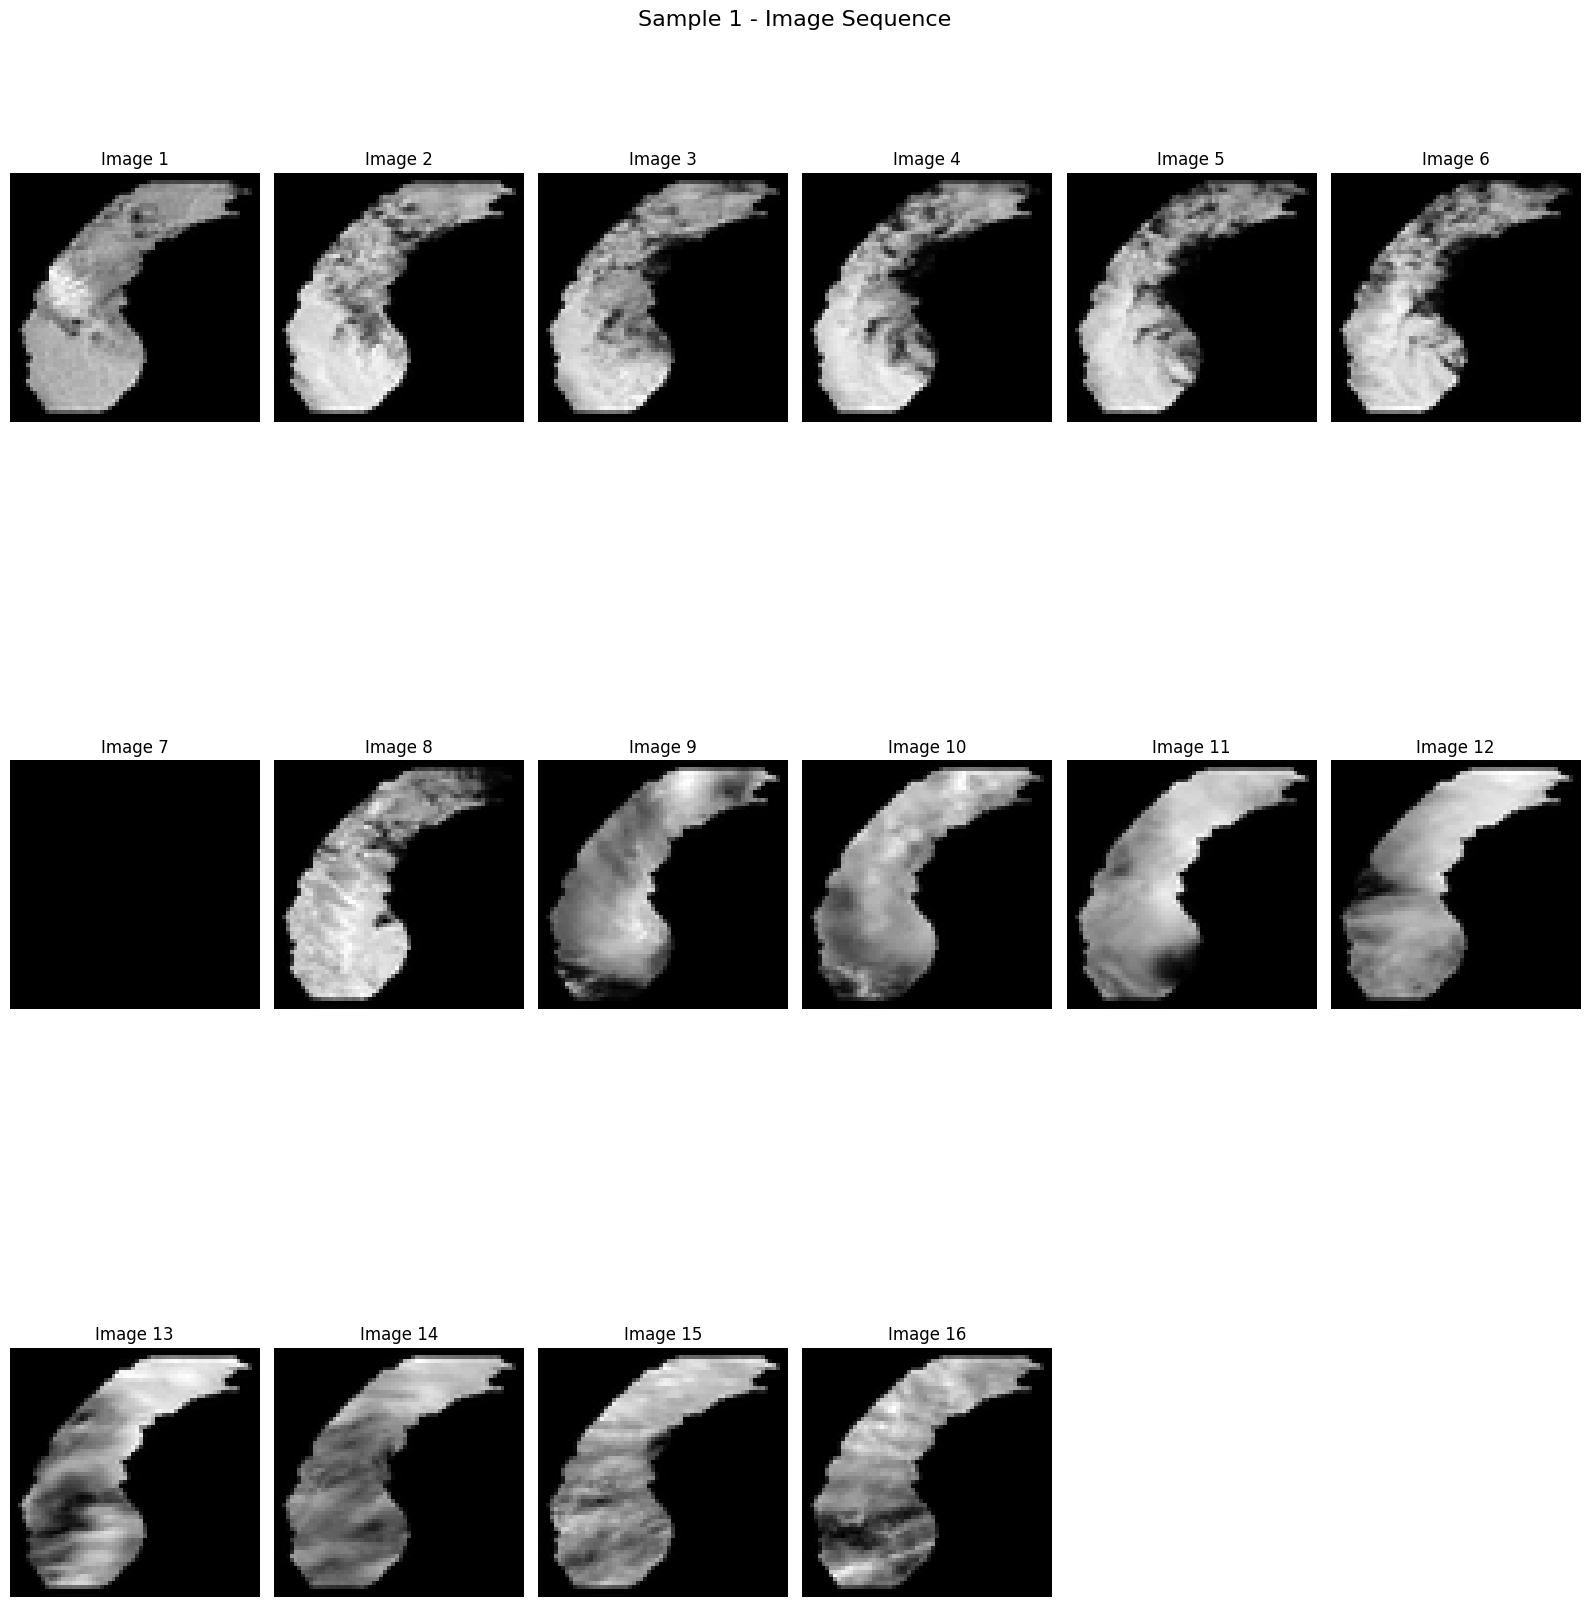


=== Sample 2 ===
Meteorological Data:
[[7.8000e+01 3.0000e+01 1.0257e+03 1.0266e+03 2.4000e+01 9.0000e+03
  1.0026e+03 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.8000e+01 3.0000e+01 1.0254e+03 1.0263e+03 2.4000e+01 8.0000e+03
  1.0023e+03 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.8000e+01 3.0000e+01 1.0254e+03 1.0261e+03 2.4000e+01 2.0000e+03
  1.0023e+03 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.7000e+01 1.8000e+01 1.0284e+03 1.0294e+03 1.2000e+01 9.0000e+03
  1.0053e+03 3.0000e+00 1.9000e+02 0.0000e+00]
 [8.0000e+01 1.8000e+01 1.0274e+03 1.0286e+03 1.3000e+01 8.0000e+03
  1.0043e+03 0.0000e+00 0.0000e+00 1.2000e+04]
 [7.6000e+01 1.9000e+01 1.0271e+03 1.0282e+03 1.3000e+01 1.2000e+04
  1.0040e+03 0.0000e+00 0.0000e+00 0.0000e+00]
 [8.0000e+01 1.8000e+01 1.0268e+03 1.0280e+03 1.3000e+01 1.2000e+04
  1.0036e+03 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.6000e+01 1.9000e+01 1.0271e+03 1.0282e+03 1.3000e+01 1.1000e+04
  1.0040e+03 0.0000e+00 0.0000e+00 0.0000e+00]
 [7.7000e+01 2.0000e+01 1.0278e+03 1.0287

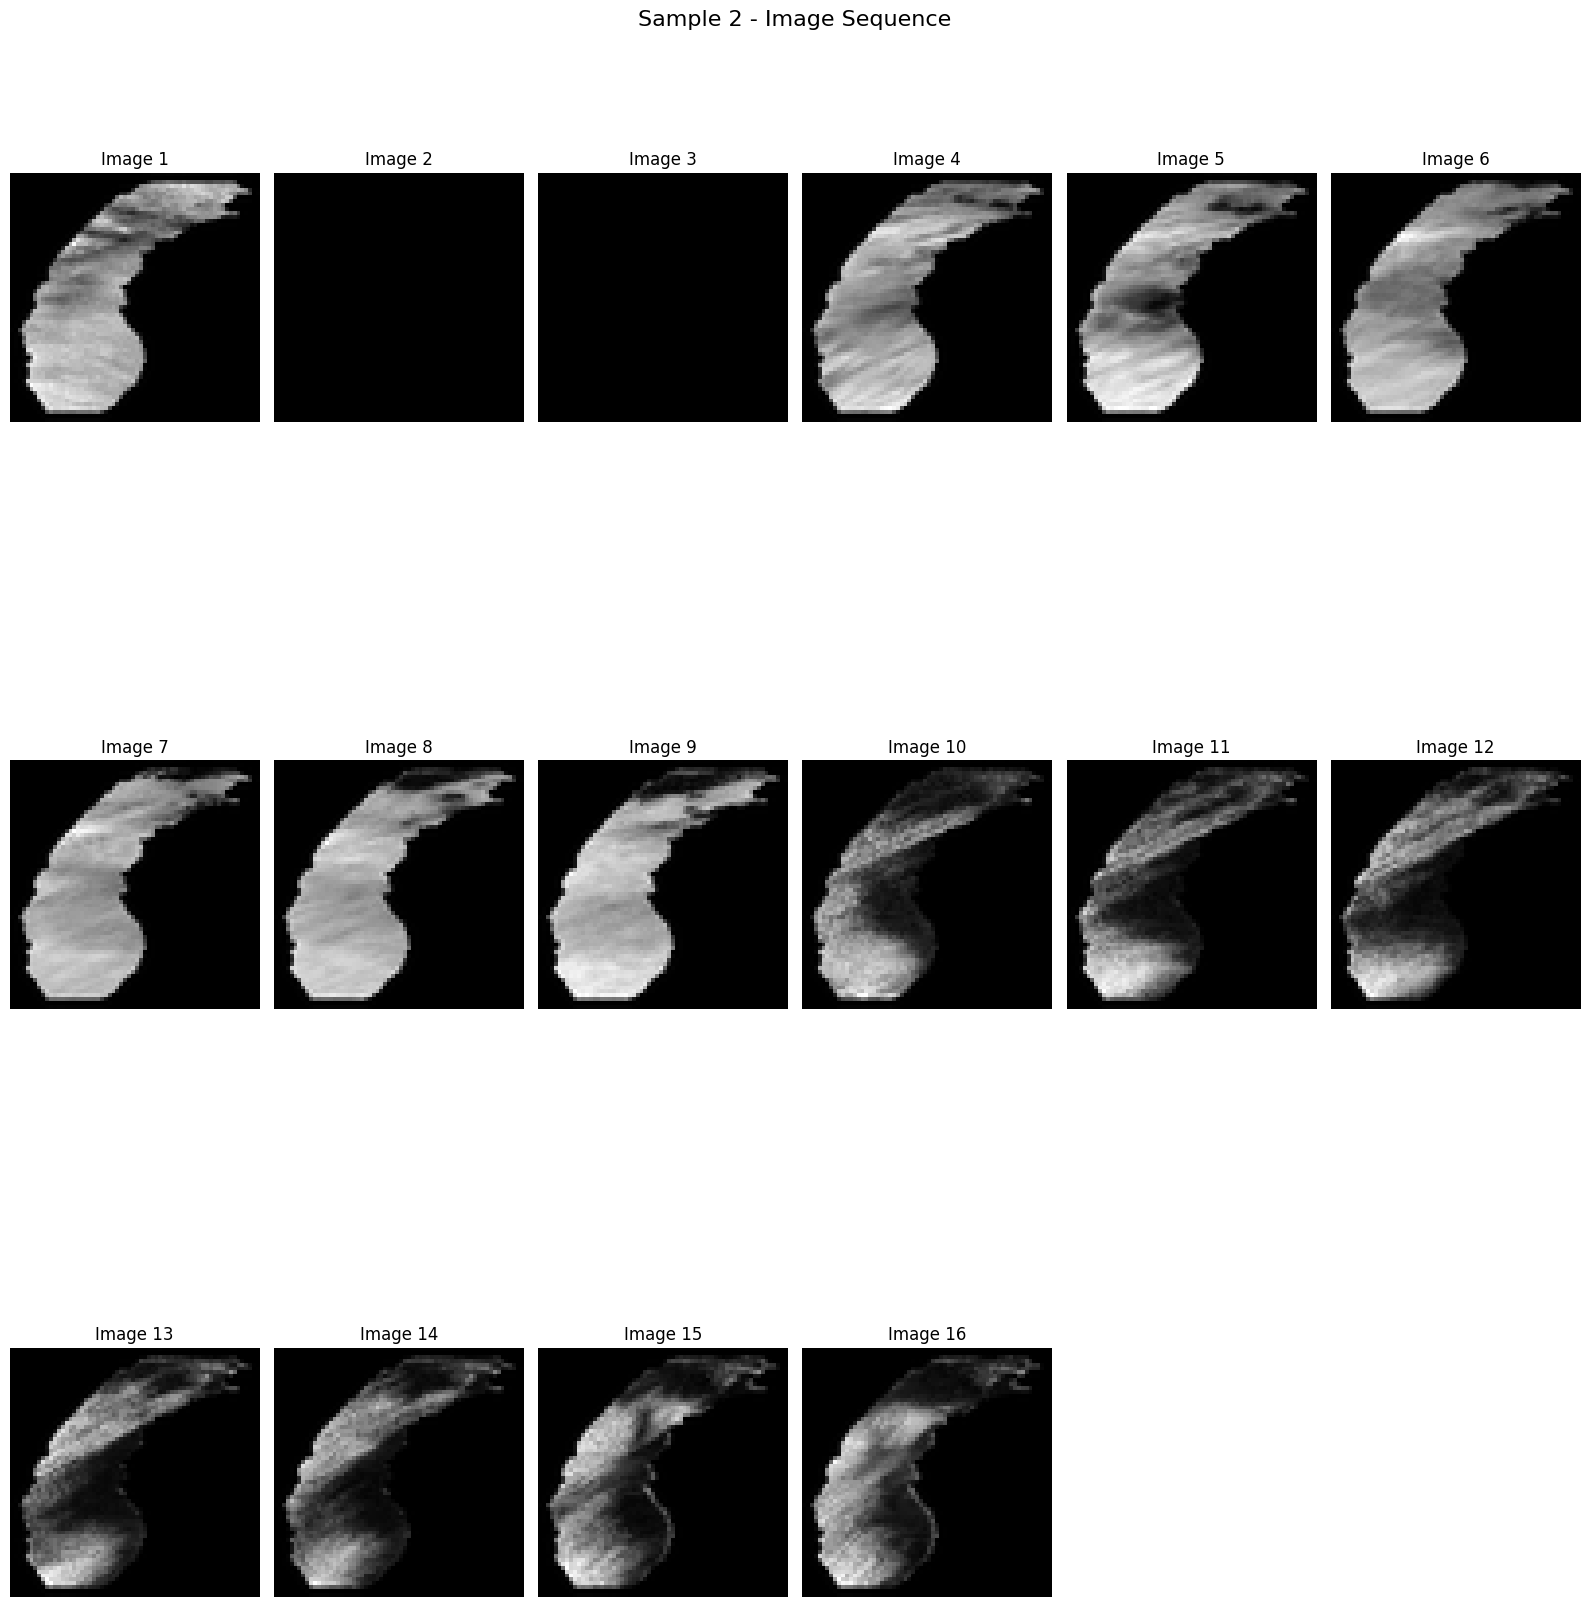

In [26]:
import matplotlib.pyplot as plt

# Fetch the first batch of data from the generator
inputs, labels, sample_weights = train_generator[0]  # First batch

# Extract image and meteorological data
sample_images = inputs['cloud_input'][:2]  # First two samples
sample_meteo = inputs['meteo_input'][:2]    # First two meteorological inputs
sample_labels = labels[:2]                  # First two labels
sample_weights = sample_weights[:2]         # First two sample weights

# Plot images for the first two samples
for sample_idx in range(2):
    print(f"\n=== Sample {sample_idx+1} ===")
    print(f"Meteorological Data:\n{sample_meteo[sample_idx]}")
    print(f"Label: {sample_labels[sample_idx]}")
    print(f"Sample Weight: {sample_weights[sample_idx]}")

    # Visualize the image sequence for each sample
    plt.figure(figsize=(16, 24))
    for img_idx in range(sample_images.shape[1]):  # Iterate through 8 images in the sequence
        plt.subplot(4, 6, img_idx + 1)
        plt.imshow(sample_images[sample_idx, img_idx].squeeze(), cmap='gray')
        plt.axis('off')
        plt.title(f'Image {img_idx + 1}')
    plt.suptitle(f"Sample {sample_idx+1} - Image Sequence", fontsize=16)
    plt.tight_layout()
    plt.show()

In [27]:
# print("Class Weights:", class_weights_manual_48)
print("Sample Weights for First Batch:", train_generator[0][2])

Sample Weights for First Batch: [9.96040868 0.269256   0.269256   0.269256   0.269256   0.269256
 0.269256   0.269256   0.269256   0.269256   0.269256   0.269256
 0.269256   0.269256   0.269256   0.269256   0.269256   0.269256
 0.269256   0.269256   0.269256   0.269256   0.269256   7.593963
 0.269256   0.269256   0.269256   0.269256   0.269256   0.269256
 0.269256   0.269256  ]


In [28]:
print([input.name for input in model_optimized.inputs])

['cloud_input', 'meteo_input']


In [29]:
# from tensorflow.keras.models import load_model

# # Path to the model checkpoint
# model_checkpoint_path = "model_checkpoints/hybrid_model_lstm_48_window_epoch_10.keras"

# loaded_model = load_model(model_checkpoint_path)
# print("Model loaded successfully.")

## 9. Model Training

We are training our hybrid model to predict target categories by integrating meteorological time-series data and satellite image sequences. The model processes meteorological inputs and cloud image sequences simultaneously, extracting complementary features to improve prediction accuracy.

To ensure robust training, we will validate the model's performance during each epoch using a separate validation dataset. By setting the training duration to 10 epochs and using a batch-based data generator, we provide the model with sufficient iterations to learn meaningful patterns while maintaining memory efficiency.

In [30]:
callbacks = [reduce_lr, checkpoint_callback]

# Remove 'class_weight' from model.fit()
history = model_optimized.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3566 - loss: 1.5952
Epoch 1: saving model to model_checkpoints/hybrid_model_lstm_48_window_automatic_weights_epoch_01.keras
975/975 ━━━━━━━━━━━━━━━━━━━━ 1417s 1s/step - accuracy: 0.3566 - loss: 1.5951 - val_accuracy: 0.3056 - val_loss: 1.4857 - learning_rate: 1.0000e-04
Epoch 2/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.3045 - loss: 1.3868
Epoch 2: saving model to model_checkpoints/hybrid_model_lstm_48_window_automatic_weights_epoch_02.keras
975/975 ━━━━━━━━━━━━━━━━━━━━ 1489s 2s/step - accuracy: 0.3046 - loss: 1.3868 - val_accuracy: 0.3155 - val_loss: 1.6366 - learning_rate: 1.0000e-04
Epoch 3/20
975/975 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3689 - loss: 1.3222
Epoch 3: saving model to model_checkpoints/hybrid_model_lstm_48_window_automatic_weights_epoch_03.keras
975/975 ━━━━━━━━━━━━━━━━━━━━ 1467s 2s/step - accuracy: 0.3689 - loss: 1.3222 - val_accuracy: 0.3373 - val_loss: 1.3221 - learning_rate: 1.0

## 10. Evaluation

Now, let's see the results of our training.

- We are evaluating our model by predicting outcomes on the validation dataset for 48 hour window.
- Once we generate the predictions, we convert them into class labels to match the format of the actual validation labels.
- This allows us to compare the model's predictions with the true labels for each time window.
- Additionally, we are preparing to analyze the results using tools like confusion matrices.
- These will visually show how well the model distinguishes between the precipitation categories by mapping true labels against predicted labels, giving us insights into the model's performance and any patterns of misclassification.

16/16 ━━━━━━━━━━━━━━━━━━━━ 8s 443ms/step
Classification Report:
               precision    recall  f1-score   support

   High Rain       0.55      0.66      0.60       126
   Less Rain       0.39      0.34      0.36       126
 Medium Rain       0.39      0.37      0.38       126
     No Rain       0.61      0.60      0.60       126

    accuracy                           0.49       504
   macro avg       0.48      0.49      0.48       504
weighted avg       0.48      0.49      0.48       504



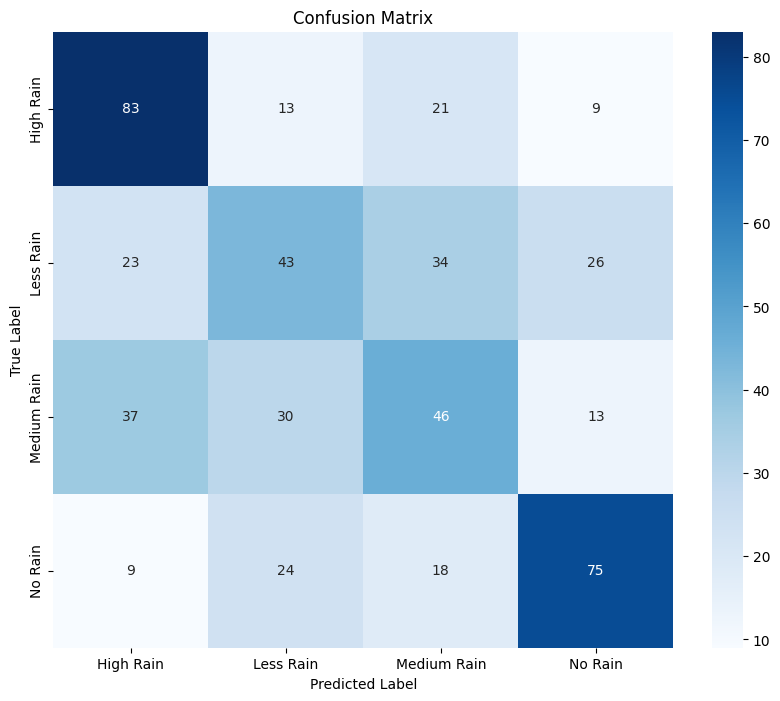

In [31]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Predict on the validation data
y_pred_probs = model_optimized.predict(val_generator)  # Predicted probabilities
y_pred = np.argmax(y_pred_probs, axis=1)       # Predicted class indices

# Step 2: Extract true labels from the validation generator
y_true = []
for i in range(len(val_generator)):
    _, y_batch = val_generator[i][:2]  # Extract batch labels
    y_true.append(np.argmax(y_batch, axis=1))

#Concatenate batches
y_true = np.concatenate(y_true)

# Step 3: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 4: Generate classification report
classes = ['High Rain', 'Less Rain', 'Medium Rain', 'No Rain']  # Adjust based on your class labels
report = classification_report(y_true, y_pred, target_names=classes)
print("Classification Report:\n", report)

# Step 5: Visualize confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


The classification reports summarize the model's performance across four precipitation categories (0, 1, 2, 3), which likely correspond to "No Rain," "Less Rain," "Medium Rain," and "High Rain." Key metrics:
- <b>Precision:</b> How many of the predicted values for a class were correct.
- <b>Recall:</b> How many actual instances of a class were correctly predicted.
- <b>F1-score:</b> The harmonic mean of precision and recall, providing a single measure of model performance.
- <b>Support:</b> The number of true instances for each class.

So, what are those colorful boxes? These are what we call Confusion Matrix.

<b>What are Confusion Matrices?</b>
    
Each matrix represents the model's prediction results compared to actual labels:
- Rows correspond to true classes.
- Columns correspond to predicted classes.
- The diagonal indicates correct predictions.
- Off-diagonal elements represent misclassifications.

When we compare the 48-hour RNN model using only meteorological data with the 48-hour hybrid model that combines meteorological and satellite image data, we can see a slight improvement in performance. The RNN-only model achieved an accuracy of 44%, whereas the hybrid model reached an accuracy of 49%. The "No Rain" category showed the biggest improvement in recall, increasing from 53% to 60%, which indicates the hybrid model's ability to better capture features contributing to the "No Rain" prediction. However, the recall for the "Less Rain" class remained low in both cases, suggesting challenges in distinguishing subtle precipitation patterns regardless of the added data modality.

When we compare the 48-hour hybrid model to the 24-hour hybrid model, we notice a slight decrease in performance, as the 24-hour hybrid model had an accuracy of 47%. This reduction may be due to the increased complexity and uncertainty introduced by a longer prediction window, as the 48-hour model predicts rainfall two days ahead instead of the next day. This likely makes it harder to capture temporal dependencies effectively, even with the additional information from satellite images.


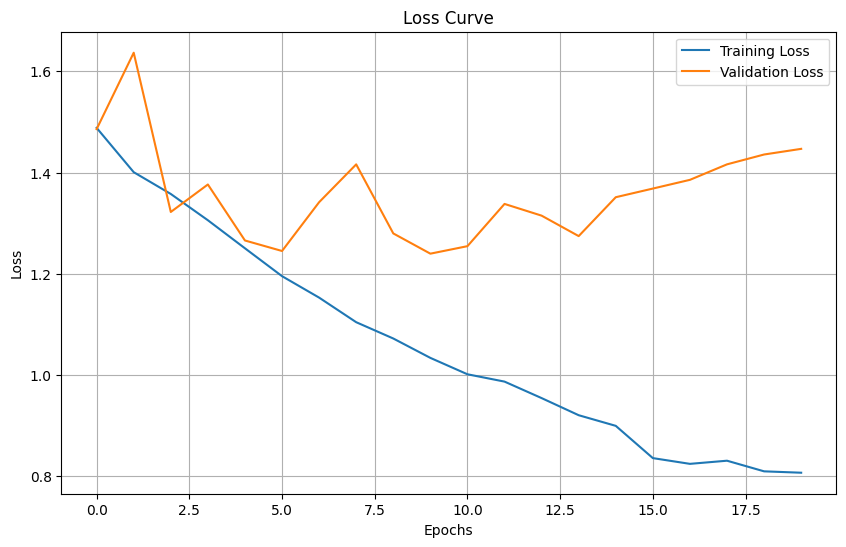

In [32]:
import matplotlib.pyplot as plt

# Example: Assuming `history` contains the training history
# history = model.fit(...)

# Plot training and validation loss
def plot_loss_curve(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Loss Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the history object
plot_loss_curve(history)


**Loss Curve:** The training loss consistently decreases, indicating that the model is learning effectively. However, the validation loss fluctuates and starts increasing after a point.

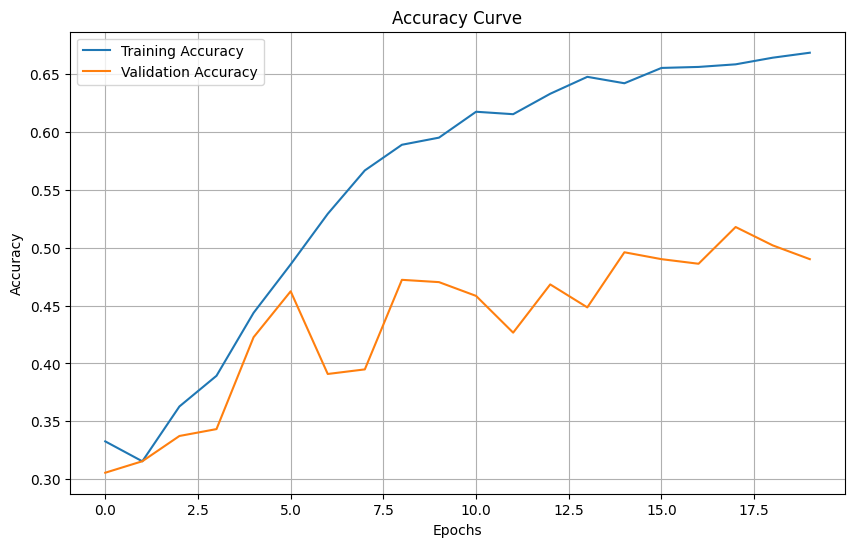

In [33]:
import matplotlib.pyplot as plt

# Function to plot training and validation accuracy
def plot_accuracy_curve(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Accuracy Curve')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Call the function with the history object
plot_accuracy_curve(history)


**Accuracy Curve:** Training accuracy steadily improves, reaching above 65%, while validation accuracy stabilizes around 50% with fluctuations, reflecting some generalization challenges.

In [34]:
# Save the history
with open('training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)